In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import pickle

from pymongo import MongoClient
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

## Connect to MongoDB - Get Spotify Data

In [2]:
client = MongoClient()
db = client.get_database('spotify')
db.list_collection_names()

['track_features', 'tracks', 'artists', 'albums', 'track_analysis']

In [3]:
cursor = db.track_features.find({}, {'_id': 0, 'duration_ms': 0,
                                     'time_signature': 0, 'tempo': 0,
                                     'mode': 0, 'key': 0})
track_features_df = pd.DataFrame(list(cursor))
track_features_df.rename(columns={'id': 'spotify_song_id'}, inplace=True)

## Grab the Genius Data and Merge

In [4]:
sentiment_features = pd.read_pickle('../Data/combined_sentiment_scores_df')
df = sentiment_features[['spotify_song_id', 'neg', 'neu', 'pos',
                         'compound', 'polarity', 'subjectivity']]

In [5]:
df = track_features_df.merge(df, on='spotify_song_id')

In [6]:
df.head(2)

,acousticness,album_uri,analysis_url,artist_uri,danceability,energy,spotify_song_id,instrumentalness,liveness,loudness,...,track_href,type,uri,valence,neg,neu,pos,compound,polarity,subjectivity
0,0.00834,spotify:album:4vQcWE7Ce6ORsatrqXkBtt,https://api.spotify.com/v1/audio-analysis/2dqp...,spotify:artist:14H7ag1wpQOsPPQJOD6Dqr,0.485,0.664,2dqpsVfEE3SWltmZ7UWb0m,0.57,0.120,-8.003,...,https://api.spotify.com/v1/tracks/2dqpsVfEE3SW...,audio_features,spotify:track:2dqpsVfEE3SWltmZ7UWb0m,0.742,0.0,0.835,0.165,0.7579,-0.060606,0.242424
1,0.51800,spotify:album:4vQcWE7Ce6ORsatrqXkBtt,https://api.spotify.com/v1/audio-analysis/3C6f...,spotify:artist:14H7ag1wpQOsPPQJOD6Dqr,0.331,0.412,3C6fiZI9I8xEMbUSfXfQCD,0.23,0.131,-8.576,...,https://api.spotify.com/v1/tracks/3C6fiZI9I8xE...,audio_features,spotify:track:3C6fiZI9I8xEMbUSfXfQCD,0.246,0.0,0.678,0.322,0.8966,0.004167,0.518452


## Separate Features Columns from other data

In [7]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [8]:
features = df.select_dtypes(include=numerics)
no_features = df.select_dtypes(exclude=numerics)

In [9]:
ss = StandardScaler()
scaled_features = ss.fit_transform(features)
scaled_features = pd.DataFrame(scaled_features)
scaled_features.columns = features.columns
track_features_df = pd.merge(no_features, scaled_features,
                             right_index=True, left_index=True)
track_features_df.rename(columns={'id': 'spotify_song_id'}, inplace=True)

## Checking Inertia

In [10]:
KMeans_df = track_features_df.select_dtypes(include=numerics)

inertia = []
i = 2
while i <= 30:
    num_clusters = i
    km = KMeans(n_clusters=num_clusters, n_jobs=-1, n_init=10)
    km.fit(KMeans_df.values)
    inertia.append(km.inertia_)
    i += 1

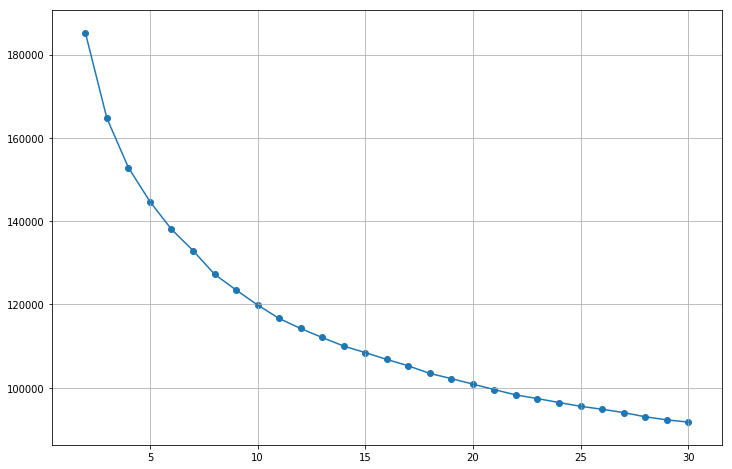

In [11]:
plt.figure(figsize=(12, 8))
plt.grid()
plt.plot(range(2, 31, 1), inertia)
plt.scatter(range(2, 31, 1), inertia)

In [12]:
km = KMeans(n_clusters=6, n_jobs=-1, n_init=10)
km.fit(KMeans_df.values)
inertia.append(km.inertia_)

In [13]:
corr_df = KMeans_df.corr()

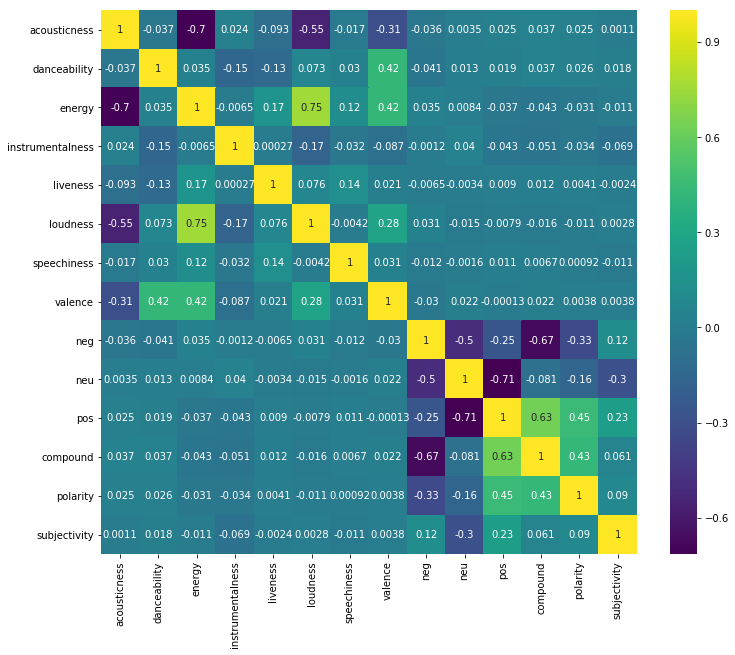

In [14]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, cmap='viridis')

In [15]:
inertia = []
i = 2
while i <= 30:
    num_clusters = i
    km = KMeans(n_clusters=num_clusters, n_jobs=-1, n_init=10)
    km.fit(KMeans_df.values)
    inertia.append(km.inertia_)
    test = pd.DataFrame(km.cluster_centers_,
                        columns=KMeans_df.columns.tolist())
    print(test.apply(lambda x: x.argmin(), axis=1).value_counts(), '\n')
    print(pd.Series(km.labels_).value_counts(), '\n')
    i += 1

energy          1
acousticness    1
dtype: int64 

0    10098
1     5208
dtype: int64 



/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  # Remove the CWD from sys.path while we load stuff.


energy          1
acousticness    1
compound        1
dtype: int64 

2    6864
1    4380
0    4062
dtype: int64 

energy      1
neu         1
compound    1
neg         1
dtype: int64 

3    4438
0    4106
1    3538
2    3224
dtype: int64 

energy      1
neu         1
compound    1
loudness    1
neg         1
dtype: int64 

2    4325
3    4102
1    3503
4    3177
0     199
dtype: int64 

energy          1
neu             1
compound        1
danceability    1
loudness        1
neg             1
dtype: int64 

1    3974
0    3561
2    3191
3    2903
5    1479
4     198
dtype: int64 

danceability    2
neg             1
neu             1
energy          1
compound        1
loudness        1
dtype: int64 

1    3707
2    3414
3    3062
6    2776
4    1412
0     746
5     189
dtype: int64 

energy          2
danceability    2
neu             1
neg             1
compound        1
loudness        1
dtype: int64 

5    3537
2    3054
0    2546
1    2253
3    1701
4    1304
7     728
6     183
d

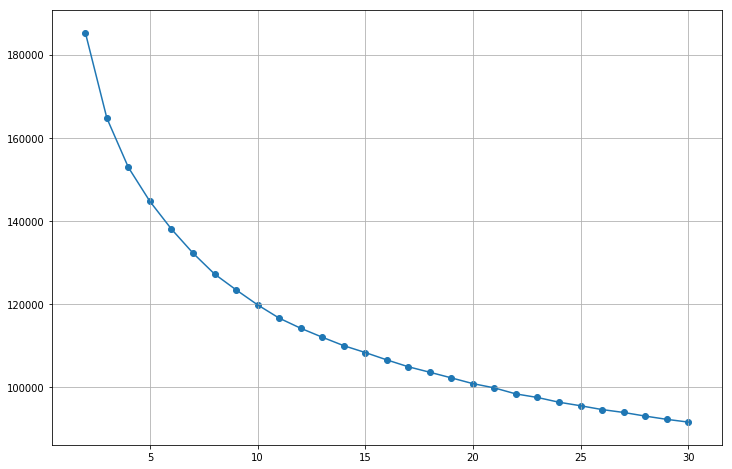

In [16]:
plt.figure(figsize=(12, 8))
plt.grid()
plt.plot(range(2, 31, 1), inertia)
plt.scatter(range(2, 31, 1), inertia)

Chose 11 clusters due to relatively even distribution of points to centroids and balanced of max feature across centroids

In [17]:
km = KMeans(n_clusters=11, n_jobs=-1, n_init=50)
km.fit(KMeans_df.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=11, n_init=50, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [18]:
km.labels_

array([0, 5, 4, ..., 9, 2, 0], dtype=int32)

In [19]:
df = (track_features_df.merge(
    pd.DataFrame(km.labels_, columns=['labels']),
    left_index=True, right_index=True))

SyntaxError: unexpected EOF while parsing (<ipython-input-19-6ac571f12103>, line 3)

In [ ]:
df.to_pickle('../Data/labeled_points')

In [ ]:
df.head()

In [ ]:
pickle_out = open('../Data/kmeans_cluster_centers_11', 'wb')
pickle.dump(km.cluster_centers_, pickle_out)
pickle_out.close()